## Логистическая регрессия и разные виды линейной регрессии (с регуляризацией)

### Датасет: [House Prices: Advanced Regression Techniques](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)

In [ ]:
!pip install scikit-learn -q
!pip install seaborn -q

In [ ]:
!pip install --upgrade statsmodels scipy

In [ ]:
!pip install statsmodels
import statsmodels.api as sm

In [ ]:
import statsmodels
import pandas as pd
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [ ]:
! gdown 1SKx5Shx5J1O45mKBmjCtQmUF7LXRUou-

Downloading...
From: https://drive.google.com/uc?id=1SKx5Shx5J1O45mKBmjCtQmUF7LXRUou-
To: /content/train.csv
100% 461k/461k [00:00<00:00, 18.9MB/s]


#### Часть 1

In [ ]:
data=pd.read_csv('train.csv', sep=',')
print(data.head())
print(data.info())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

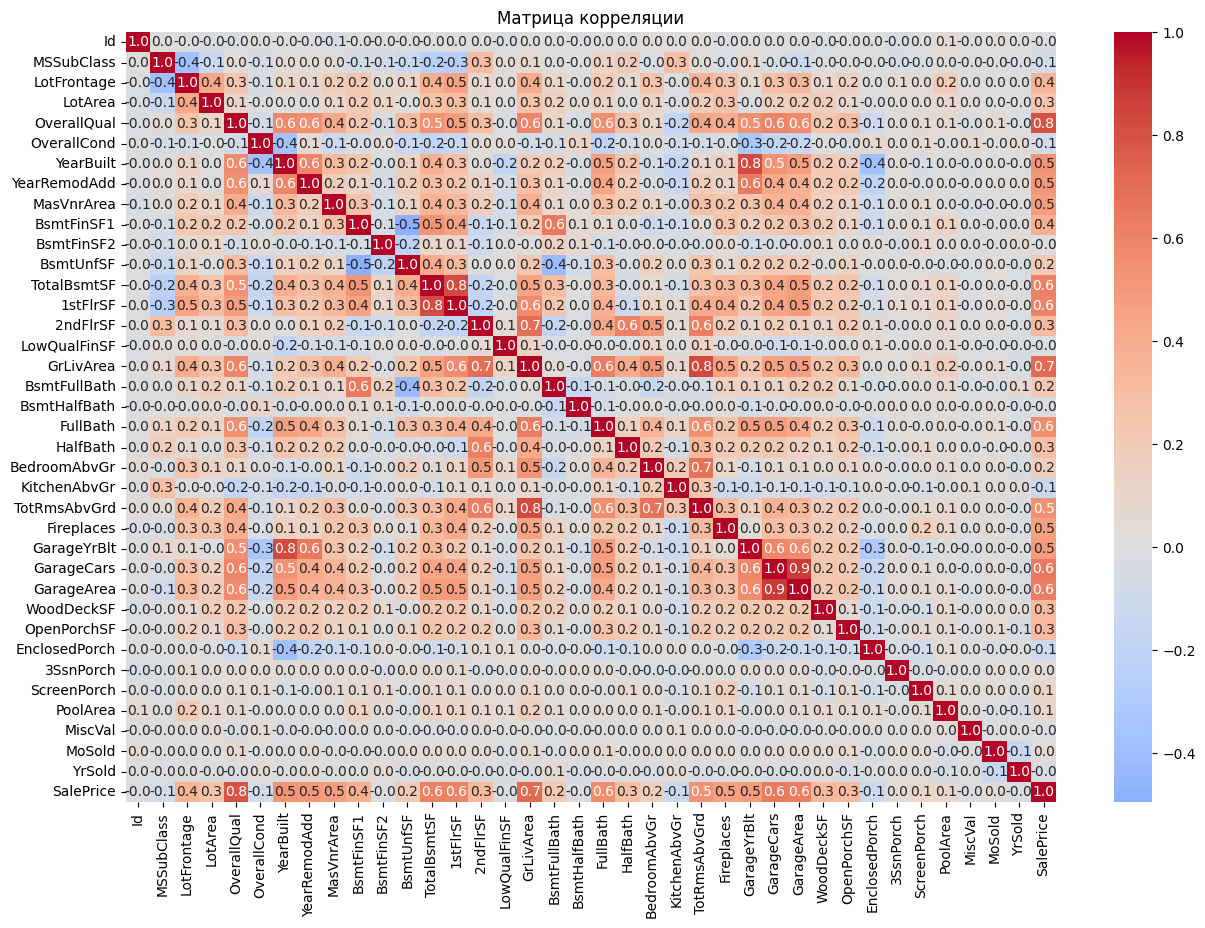

In [ ]:
#посмотрим на матр. кор. для числовых столбцов :
num_data = data.select_dtypes(include=[np.number])
corr = num_data.corr()
plt.figure(figsize=(15, 10))
sns.heatmap(corr, annot=True, fmt=".1f", cmap='coolwarm', center=0)
plt.title('Матрица корреляции')
plt.show()

Статистика SalePrice:
count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


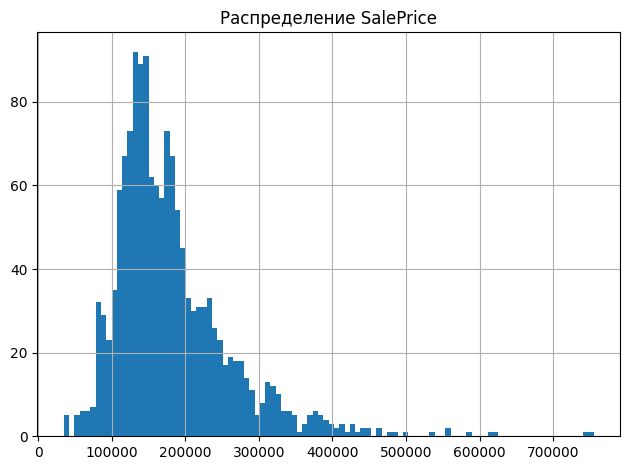

In [ ]:
print("Статистика SalePrice:")
print(data['SalePrice'].describe())

data['SalePrice'].hist(bins=100)
plt.title('Распределение SalePrice')
plt.tight_layout()
plt.show()

LotFrontage      259
Alley           1369
MasVnrType       872
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      690
GarageType        81
GarageYrBlt       81
GarageFinish      81
GarageQual        81
GarageCond        81
PoolQC          1453
Fence           1179
MiscFeature     1406
dtype: int64


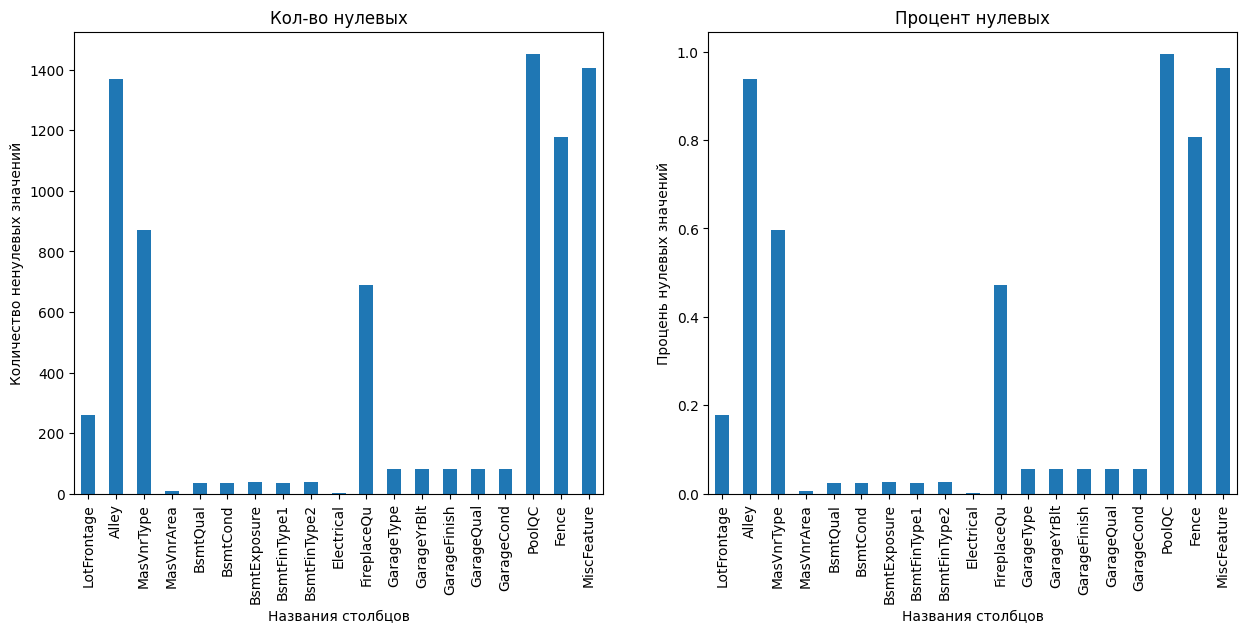

In [ ]:
data_null=data.isnull().sum()
print(data_null[data_null>0])
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
data_null[data_null>0].plot(kind='bar')
plt.title('Кол-во нулевых')
plt.xlabel('Названия столбцов')
plt.ylabel('Количество ненулевых значений')
plt.subplot(1, 2, 2)
datanullpr=data_null[data_null>0]/data.shape[0]
datanullpr.plot(kind='bar')
plt.title('Процент нулевых')
plt.xlabel('Названия столбцов')
plt.ylabel('Процень нулевых значений')
plt.show()

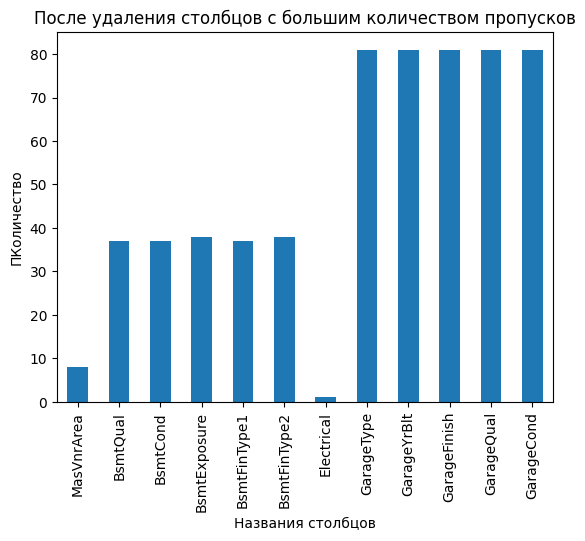

Итого сумма всех пропусков в таблице: 0


In [ ]:
#Я не знаю, как правильно, но почитала что лучше всего дропнуть не все значения, а те, где процент пропусков значителен(удаляем столбец)
#а в оставшихся заполнить медианой/дропнуть строки

miss_alot=datanullpr[datanullpr>0.15].index
data1=data.drop(columns=miss_alot)
datanew=data1.isnull().sum()
datanew[datanew>0].plot(kind='bar')
plt.title('После удаления столбцов с большим количеством пропусков')
plt.xlabel('Названия столбцов')
plt.ylabel('ПКоличество')
plt.show()

# Видим, что оставшиеся пропуски - либо про подвал, либо про гараж, либо очень незначительны. Последние дропаем(<1%). А для гаража и
# подвала смотрим на матр корр и видим что (к сожалению) корреляция достаточно большая с SalePrice и поэтому лучше заменить такие пропуски
# на медиану, а не дропать.

missfew=datanullpr[datanullpr<0.01].index
data1=data1.dropna(subset=missfew)

num_gb = data1.select_dtypes(include=[np.number]).columns
ctg_gb = data1.select_dtypes(include=['object', 'category']).columns
for col in ctg_gb:
    if data1[col].isnull().sum() > 0:
        mode_val = data1[col].mode()[0]
        data1[col] = data1[col].fillna(mode_val)

for col in num_gb:
    if data1[col].isnull().sum() > 0:
        fill_val = data1[col].median()
        data1[col] = data1[col].fillna(fill_val)

print('Итого сумма всех пропусков в таблице:', data1.isnull().sum().sum())

In [ ]:
y=data1['SalePrice']
X=data1.drop('SalePrice', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_sm = sm.add_constant(X_train.select_dtypes(include=[np.number]))
X_test_sm = sm.add_constant(X_test.select_dtypes(include=[np.number]))

model_ols=sm.OLS(y_train, X_train_sm).fit()
y_pred_ols = model_ols.predict(X_test_sm)
mse_ols = mean_squared_error(y_test, y_pred_ols)
r2_ols = r2_score(y_test, y_pred_ols)
print(f"MSE: {mse_ols:.4f}, RMSE: {(mse_ols)**0.5:.4f}, R²: {r2_ols:.4f}")

MSE: 773222704.3384, RMSE: 27806.8823, R²: 0.8614


Обоснование выбора метрики:

Чаще всего для ЛР используется MSE/R2


#### Часть 2

In [ ]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression

num = X.select_dtypes(include=[np.number]).columns
ctg = X.select_dtypes(include=['object', 'category']).columns

# я поняла комментарии по поводу первых двух пунктов, но т.к. этого не было на занятии, скопировала функцию из инета
preprocessor = ColumnTransformer(transformers=[('num', StandardScaler(), num),('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ctg)])

X_train_pr = preprocessor.fit_transform(X_train)
X_test_pr = preprocessor.transform(X_test)

lr = LinearRegression()
lr.fit(X_train_pr, y_train)
y_pred = lr.predict(X_test_pr)
mse_lr = mean_squared_error(y_test, y_pred)
r2_lr = r2_score(y_test, y_pred)
print(f"MSE: {mse_lr:.4f}, RMSE: {(mse_lr)**0.5:.4f}, R²: {r2_lr:.4f}")

ft = preprocessor.get_feature_names_out()
ft_coef = pd.DataFrame({'fts': ft, 'coefs': abs(lr.coef_)})
ft_coef=ft_coef.sort_values('coefs', ascending=False)
print('Топ5: ', ft_coef.head())

MSE: 0.0996, RMSE: 0.3156, R²: 0.5717
Топ5:                         fts     coefs
113  cat__RoofMatl_WdShake  2.513548
109  cat__RoofMatl_CompShg  2.379149
111     cat__RoofMatl_Roll  2.354884
114  cat__RoofMatl_WdShngl  2.132056
112  cat__RoofMatl_Tar&Grv  2.073906


Ээээ, ну, я честно попыталась понять, в чем ошибка, но к сожалению не нашла ахах) Возможно, в штате Айова и правда самое главное - КРЫША над головой ))

# Часть 3
Регуляризация и подбор гиперпараметров


In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

In [ ]:
import warnings
warnings.filterwarnings('ignore')
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.linear_model import ElasticNet
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

pipeline1 = Pipeline([
    ('preprocessor2', ColumnTransformer([('num', MinMaxScaler(), num), ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ctg)])),
    ('elastic', ElasticNet(random_state=42, max_iter=10000))
])

pipeline2 = Pipeline([
    ('preprocessor2', ColumnTransformer([('num', StandardScaler(), num),('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ctg)])),
    ('elastic', ElasticNet(random_state=42, max_iter=10000))
])

param_grid = {
    'elastic__alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'elastic__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 0.95, 0.98]
}

grid_search1 = GridSearchCV(
    estimator=pipeline1,
    param_grid=param_grid,
    cv=5,
    scoring='r2'
)
grid_search1.fit(X_train, y_train)
print(f"Лучшие параметры: {grid_search1.best_params_}")
print(f"Лучший R2_score: {grid_search1.best_score_:.4f}")

Лучшие параметры: {'elastic__alpha': 0.1, 'elastic__l1_ratio': 0.9}
Лучший R2_score: 0.8058


хэпи хэпи хэпиии

In [ ]:
grid_search2 = GridSearchCV(
    estimator=pipeline2,
    param_grid=param_grid,
    cv=5,
    scoring='r2'
)
grid_search2.fit(X_train, y_train)
print(f"Лучшие параметры: {grid_search2.best_params_}")
print(f"Лучший R2_score: {grid_search2.best_score_:.4f}")

Лучшие параметры: {'elastic__alpha': 0.01, 'elastic__l1_ratio': 0.3}
Лучший R2_score: 0.7696


он работал 5 минут... ради R2=0.77

#### Часть 4
Сравнение

Ответ на вопрос: ну это просто без комментариев реально!!! Сравним R2_score: LR - 0.86, MMScaler=0.81, StandardScaler=0.76. Aplha в первом случае 0.1, во втором 0.01; l1 вообще как-то не очень сошелся... В одном случае 0.9, во втором 0.3 - получается, с минмаксскейлер очень сильно обнуляет признаки, а в стендардскейлер нет. Но, опираясь на R2_score, видимо, лучше MinMaxScaler. Из плюсов - как я понимаю, метрики улучшились по сравнению с прошлым заданием, так как мы занулили признаки, которые давали шум, а не реальную пользу.

In [ ]:
grid_search3 = GridSearchCV(
    estimator=pipeline1,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)
grid_search3.fit(X_train, y_train)
print(f"Лучшие параметры: {grid_search3.best_params_}")
print(f"Лучший RMSE: {(-grid_search3.best_score_)**0.5:.4f}")

Лучшие параметры: {'elastic__alpha': 0.1, 'elastic__l1_ratio': 0.9}
Лучший RMSE: 35009.7124


In [ ]:
grid_search4 = GridSearchCV(
    estimator=pipeline2,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error'
)
grid_search4.fit(X_train, y_train)
print(f"Лучшие параметры: {grid_search4.best_params_}")
print(f"Лучший RMSE: {(-grid_search4.best_score_)**0.5:.4f}")

Лучшие параметры: {'elastic__alpha': 0.01, 'elastic__l1_ratio': 0.3}
Лучший RMSE: 37863.7027


Я все-таки поняла, что кажется R2-score одного недостаточно, потому что он не улавливает масштаб ошибки, поэтому решила сделать ещё и RMSE, итоги: просто LR ~27,8 тыс., MinMaxScaler ~ 35 тыс., StandardScaler ~ 37,8 тыс.

### Часть 5

In [ ]:
from sklearn.linear_model import LogisticRegression

med = data1['SalePrice'].mean()
data1['expensive']= (data1['SalePrice']>med).astype(int)

y = data1['expensive']
X = data1.drop(['SalePrice', 'expensive'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
num=X.select_dtypes(include=[np.number]).columns
ctg=X.select_dtypes(include=['object', 'category']).columns
pipeline = Pipeline([
    ('preprocessor2', ColumnTransformer([('num', MinMaxScaler(), num), ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), ctg)])),
    ('LogReg', LogisticRegression(penalty='l2',random_state=42,max_iter=1000,solver='liblinear'))
])

param_grid = {'LogReg__C': [0.001, 0.01, 0.1, 1, 10, 100]}

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    cv=5,
    scoring='f1'
)
grid_search.fit(X_train, y_train)
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучший f1_score: {grid_search.best_score_:.4f}")

Лучшие параметры: {'LogReg__C': 1}
Лучший f1_score: 0.8885


Хороший f1_score!

In [ ]:
pipelinebs = grid_search.best_estimator_
ft=pipelinebs.named_steps['preprocessor2'].get_feature_names_out()
coef=abs(pipelinebs.named_steps['LogReg'].coef_[0])
ft_coef=pd.DataFrame({
    'ft': ft, 'coef': coef
})
print(ft_coef.sort_values('coef', ascending=False).head(5))

                   ft      coef
13      num__2ndFlrSF  1.967197
18      num__FullBath  1.847296
3    num__OverallQual  1.765882
15     num__GrLivArea  1.754147
22  num__TotRmsAbvGrd  1.652146


Проанализируй все модели и ответе на вопросы :(2 балла)

1) Какая модель показала наилучшие результаты для регрессии и почему?

2) Как регуляризация повлияла на веса признаков?

3) Какие признаки оказались наиболее важными для предсказания цены дома?

4) Насколько хорошо логистическая регрессия справилась с бинарной классификацией?

5) Какие проблемы в данных могли повлиять на качество моделей?

Ответ на вопросы:
1. Я везде сравнивала по R2 и RMSE, поэтому если расставить в порядке улучшения, то у меня получится: LR с категориальными без GridSearchCV<с Standard<с MinMax<LR с числовыми

2. Не совсем поняла вопрос, Elastic Net очевидно в обоих случаях сильно повлиял на веса признаков - из-за этого улучшились метрики, так как уменьшило шум с категориальных признаков

3. Выше выводила топ5 для LR с ктг признаками и лог. регрессии

4. f1_score~0.88 считается очень хорошим

5. Мне кажется, что в худшую сторону сказалось добавление категориальный признаков с OneHotEncoder :( Возможно, это переобучение и эти признаки добавляют больше шум нежели что-то важное